# Preamble

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as Data
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from matplotlib import pyplot as plt
from scipy.ndimage.interpolation import rotate
import nibabel as nb
from google.colab import drive
import glob
import os, sys
drive.mount('/content/drive',  force_remount=True)

Mounted at /content/drive


# Data Reading

In [ ]:
def load_3D( name):
    # model_np = np.zeros(shape=(160, 192, 224))
    # X_nb = nb.load(name)
    # X_np = X_nb.dataobj
    # #print("Oreintation: {}".format(nb.aff2axcodes(X_nb.affine)))
    # model_np[:, :, :] = X_np[42:202, 32:224, 16:240]
    # #model_np = np.reshape(model_np, (1,)+ model_np.shape)
    # return model_np
    resamplng_shape = (128, 128, 128)
    

    X_nb = nb.load(name)
    X_np = X_nb.dataobj
    least_intensity = np.min(X_np)
    model_np = np.full(shape=resamplng_shape, fill_value=least_intensity)

    #X_np = imgnorm(X_np_old)
    x_dim, y_dim, z_dim = X_np.shape
    x_ltail = (resamplng_shape[0] - x_dim)//2 
    y_ltail = (resamplng_shape[1] - y_dim)//2
    z_ltail = (resamplng_shape[2] - z_dim)//2

    x_rtail = resamplng_shape[0] - x_ltail - 1
    y_rtail = resamplng_shape[1] - y_ltail - 1
    z_rtail = resamplng_shape[2] - z_ltail - 1
    #print("Oreintation: {}".format(nb.aff2axcodes(X_nb.affine)))
    #model_np[:, :, :] = X_np[42:202, 32:224, 16:240]
    model_np[x_ltail:x_rtail, y_ltail:y_rtail, z_ltail:z_rtail] = X_np[:, :, :]
    model_np = np.reshape(model_np, (1,)+ model_np.shape)
    model_np = np.reshape(model_np, (1,)+ model_np.shape)
    #myimg = imgnorm(model_np)
    return model_np

def load_4D(name):
    # (256, 256, 256)
    model_np = np.zeros(shape=(128, 128, 128))
    X_nb = nb.load(name)
    
    X_np = X_nb.dataobj
    #print("Oreintation: {}".format(nb.aff2axcodes(X_nb.affine)))
    #model_np[:, :, 0:X_np.shape[2]] = X_np[0:128, 0:128, :]
    #model_np = np.reshape(model_np, (1,)+ model_np.shape)
    model_np = np.reshape(X_np, (1,)+ X_np.shape)
    model_np = np.reshape(model_np, (1,)+ model_np.shape)
    return model_np

def imgnorm(N_I,index1=0.0001,index2=0.0001):
    I_sort = np.sort(N_I.flatten())
    I_min = I_sort[int(index1*len(I_sort))]
    I_max = I_sort[-int(index2*len(I_sort))]
    N_I =1.0*(N_I-I_min)/(I_max-I_min)
    N_I[N_I>1.0]=1.0
    N_I[N_I<0.0]=0.0
    N_I2 = N_I.astype(np.float32)
    return N_I2


def Norm_Zscore( img):
    img= (img-np.mean(img))/np.std(img) 
    return img


def run3functions( fp):
    myimg = load_4D(fp)
    myimg2 = imgnorm(myimg)
    return myimg2


In [ ]:
# data_path_fixed = "/content/drive/MyDrive/DATASET_FINAL/Test/intramodal/T1/pairwise_registered/Batch_1"
# data_path_moving = "/content/drive/MyDrive/DATASET_FINAL/Test/intramodal/T1/pairwise_registered/Batch_1_F_Batch_2_M"
# data_path_warped = '/content/drive/MyDrive/DATASET_FINAL/Test/intramodal/T1/pairwise_registered/direct_optimization_adamw_registered_Batch1_F_Batch_2_M'
data_path_fixed = "/content/drive/MyDrive/DATASET_FINAL/Test/intermodal/Batch_1/T1_F_T2_M/T1"
data_path_moving = "/content/drive/MyDrive/DATASET_FINAL/Test/intermodal/Batch_1/T1_F_T2_M/T2_affine"
data_path_warped = '/content/drive/MyDrive/DATASET_FINAL/Test/intermodal/Batch_1/direct_optimization_sgd_T1_F_T2_M'
data_path_lst_fixed = sorted(glob.glob(os.path.join(data_path_fixed, "*.nii.gz")))
data_path_lst_fixed = data_path_lst_fixed[:3]
data_path_lst_moving = sorted(glob.glob(os.path.join(data_path_moving, "*.nii.gz")))
data_path_lst_moving = data_path_lst_moving[:3]

- Create a list of deformation fields with same number as fixed images
- Read fixed images and put the tensors into a list
- Read moving images and put the tensors into a list


In [ ]:
deformation_field_tnsr_lst = [ ]
fixed_img_tnsr_lst = []
moving_img_tnsr_lst = []
for i in range(len(data_path_lst_fixed)):
  deformation_field_tnsr = torch.randn(size = (1,3,128,128,128)).to("cuda") * 0.00001
  deformation_field_tnsr.requires_grad = True
  deformation_field_tnsr_lst.append(deformation_field_tnsr)

  fixed_img_tnsr = torch.from_numpy(run3functions(data_path_lst_fixed[i])).to("cuda")
  fixed_img_tnsr.requires_grad = False
  fixed_img_tnsr_lst.append(fixed_img_tnsr)

  moving_img_tnsr = torch.from_numpy(run3functions(data_path_lst_moving[i])).to("cuda")
  moving_img_tnsr.requires_grad = False
  moving_img_tnsr_lst.append(moving_img_tnsr)




# Deformation field integration

In [ ]:
class VecInt(nn.Module):
    """
    Integrates a vector field via scaling and squaring.
    """

    def __init__(self, inshape, nsteps):
        super().__init__()
        
        assert nsteps >= 0, 'nsteps should be >= 0, found: %d' % nsteps
        self.nsteps = nsteps
        self.scale = 1.0 / (2 ** self.nsteps)
        self.transformer = SpatialTransformer(size = inshape)

    def forward(self, vec):
        vec = vec * self.scale
        for _ in range(self.nsteps):
            vec = vec + self.transformer(vec, vec)
        return vec


class ResizeTransform(nn.Module):
    """
    Resize a transform, which involves resizing the vector field *and* rescaling it.
    """

    def __init__(self, vel_resize, ndims):
        super().__init__()
        self.factor = 1.0 / vel_resize
        self.mode = 'linear'
        if ndims == 2:
            self.mode = 'bi' + self.mode
        elif ndims == 3:
            self.mode = 'tri' + self.mode

    def forward(self, x):
        if self.factor < 1:
            # resize first to save memory
            x = F.interpolate(x, align_corners=True, scale_factor=self.factor, mode=self.mode, recompute_scale_factor=True)
            x = self.factor * x

        elif self.factor > 1:
            # multiply first to save memory
            x = self.factor * x
            x = F.interpolate(x, align_corners=True, scale_factor=self.factor, mode=self.mode, recompute_scale_factor=True)

        # don't do anything if resize is 1
        return x

# Losses

In [ ]:
class NormalizedCrossCorrelation(nn.Module):
    """ N-dimensional normalized cross correlation (NCC)
    Args:
        eps (float, optional): Epsilon value for numerical stability. Defaults to 1e-8.
        return_map (bool, optional): If True, also return the correlation map. Defaults to False.
        reduction (str, optional): Specifies the reduction to apply to the output:
            ``'mean'`` | ``'sum'``. Defaults to ``'mean'``.
    """
    def __init__(self,
                 eps=1e-8,
                 return_map=False,
                 reduction='mean'):

        super(NormalizedCrossCorrelation, self).__init__()

        self._eps = eps
        self._return_map = return_map
        self._reduction = reduction

    def forward(self, x, y):

        return normalized_cross_correlation(x, y,self._return_map, self._reduction, self._eps)

In [ ]:
def normalized_cross_correlation(x, y, return_map, reduction='mean', eps=1e-8):
    """ N-dimensional normalized cross correlation (NCC)
    Args:
        x (~torch.Tensor): Input tensor.
        y (~torch.Tensor): Input tensor.
        return_map (bool): If True, also return the correlation map.
        reduction (str, optional): Specifies the reduction to apply to the output:
            ``'mean'`` | ``'sum'``. Defaults to ``'sum'``.
        eps (float, optional): Epsilon value for numerical stability. Defaults to 1e-8.
    Returns:
        ~torch.Tensor: Output scalar
        ~torch.Tensor: Output tensor
    """

    shape = x.shape
    b = shape[0]

    # reshape
    x = x.view(b, -1)
    y = y.view(b, -1)

    # mean
    x_mean = torch.mean(x, dim=1, keepdim=True)
    y_mean = torch.mean(y, dim=1, keepdim=True)

    # deviation
    x = x - x_mean
    y = y - y_mean

    dev_xy = torch.mul(x,y)
    dev_xx = torch.mul(x,x)
    dev_yy = torch.mul(y,y)

    dev_xx_sum = torch.sum(dev_xx, dim=1, keepdim=True)
    dev_yy_sum = torch.sum(dev_yy, dim=1, keepdim=True)

    ncc = torch.div(dev_xy + eps / dev_xy.shape[1],
                    torch.sqrt( torch.mul(dev_xx_sum, dev_yy_sum)) + eps)
    ncc_map = ncc.view(b, *shape[1:])

    # reduce
    if reduction == 'mean':
        ncc = torch.mean(torch.sum(ncc, dim=1))
    elif reduction == 'sum':
        ncc = torch.sum(ncc)
    else:
        raise KeyError('unsupported reduction type: %s' % reduction)

    if not return_map:
        return ncc
    
    if (torch.isclose(torch.tensor([-1.0]).to("cuda"), ncc).any()):
      ncc = ncc + torch.tensor([0.01]).to("cuda")

    elif (torch.isclose(torch.tensor([1.0]).to("cuda"), ncc).any()):
      ncc = ncc - torch.tensor([0.01]).to("cuda")

    return ncc, ncc_map


In [ ]:
def mae_loss(input, target):
    y_true_f = input.view(-1)
    y_pred_f = target.view(-1)
    diff = torch.abs(y_true_f-y_pred_f)
    mae = diff.mean() 
    return mae

In [ ]:
class Grad:
    """
    N-D gradient loss.
    """

    def __init__(self, penalty='l1', loss_mult=None):
        self.penalty = penalty
        self.loss_mult = loss_mult
        super(Grad, self).__init__()

    def loss(self, _, y_pred):
        dy = torch.abs(y_pred[:, :, 1:, :, :] - y_pred[:, :, :-1, :, :])
        dx = torch.abs(y_pred[:, :, :, 1:, :] - y_pred[:, :, :, :-1, :])
        dz = torch.abs(y_pred[:, :, :, :, 1:] - y_pred[:, :, :, :, :-1])

        if self.penalty == 'l2':
            dy = dy * dy
            dx = dx * dx
            dz = dz * dz

        d = torch.mean(dx) + torch.mean(dy) + torch.mean(dz)
        grad = d / 3.0

        if self.loss_mult is not None:
            grad *= self.loss_mult
        return grad

In [ ]:


class MutualInformation(nn.Module):

	def __init__(self, sigma=0.4, num_bins=30, normalize=True):
		super(MutualInformation, self).__init__()

		self.sigma = 2*sigma**2
		self.num_bins = num_bins
		self.normalize = normalize
		self.epsilon = 1e-10

		self.bins = nn.Parameter(torch.linspace(0, 255.0, num_bins, device='cuda').float(), requires_grad=True)


	def marginalPdf(self, values):

		residuals = values - self.bins.unsqueeze(0).unsqueeze(0)
		kernel_values = torch.exp(-0.5*(residuals / self.sigma).pow(2))
		
		pdf = torch.mean(kernel_values, dim=1)
		normalization = torch.sum(pdf, dim=1).unsqueeze(1) + self.epsilon
		pdf = pdf / normalization
		
		return pdf, kernel_values


	def jointPdf(self, kernel_values1, kernel_values2):

		joint_kernel_values = torch.matmul(kernel_values1.transpose(1, 2), kernel_values2) 
		normalization = torch.sum(joint_kernel_values, dim=(1,2)).view(-1, 1, 1) + self.epsilon
		pdf = joint_kernel_values / normalization

		return pdf


	def getMutualInformation(self, input1, input2):
		'''
			input1: B, C, H, W, D
			input2: B, C, H, W, D
			return: scalar
		'''

		# Torch tensors for images between (0, 1)
		input1 = input1*255
		input2 = input2*255

		B, C, H, W, D = input1.shape

		x1 = input1.view(B, H*W*D, C)
		x2 = input2.view(B, H*W*D, C)
		
		pdf_x1, kernel_values1 = self.marginalPdf(x1)
		pdf_x2, kernel_values2 = self.marginalPdf(x2)
		pdf_x1x2 = self.jointPdf(kernel_values1, kernel_values2)

		H_x1 = -torch.sum(pdf_x1*torch.log2(pdf_x1 + self.epsilon), dim=1)
		H_x2 = -torch.sum(pdf_x2*torch.log2(pdf_x2 + self.epsilon), dim=1)
		H_x1x2 = -torch.sum(pdf_x1x2*torch.log2(pdf_x1x2 + self.epsilon), dim=(1,2))

		mutual_information = H_x1 + H_x2 - H_x1x2
		
		if self.normalize:
			mutual_information = 2*mutual_information/(H_x1+H_x2)

		return mutual_information


	def forward(self, input1, input2):
		'''
			input1: B, C, H, W
			input2: B, C, H, W
			return: scalar
		'''
		return self.getMutualInformation(input1, input2)


In [ ]:
nmi = MutualInformation()
nmi_similarity = nmi(fixed_img_tnsr_lst[0].contiguous(),moving_img_tnsr_lst[2].contiguous() )
nmi_similarity

tensor([1.5519], device='cuda:0', grad_fn=<DivBackward0>)

# Spatial Transformer

In [ ]:
class SpatialTransformer(nn.Module):
    """
    N-D Spatial Transformer
    """

    def __init__(self, size, is_affine=False, theta = None, mode='bilinear', affine_image_size =  (1, 1, 128, 128, 128)):
        super().__init__()

        self.mode = mode
        self.isaffine = is_affine
        self.theta = theta
        self.affine_image_size =  affine_image_size
        # create sampling grid
        # registering the grid as a buffer cleanly moves it to the GPU, but it also
        # adds it to the state dict. this is annoying since everything in the state dict
        # is included when saving weights to disk, so the model files are way bigger
        # than they need to be. so far, there does not appear to be an elegant solution.
        # see: https://discuss.pytorch.org/t/how-to-register-buffer-without-polluting-state-dict

        if (self.isaffine):
          grid = F.affine_grid(self.theta, self.affine_image_size, align_corners=False)
          #grid = grid.permute(0, 4, 1, 2, 3)
          self.register_buffer('grid', grid)
        else:
          vectors = [torch.arange(0, s) for s in size]
          grids = torch.meshgrid(vectors)
          grid = torch.stack(grids)
          grid = torch.unsqueeze(grid, 0)
          grid = grid.type(torch.FloatTensor)
          self.register_buffer('grid', grid)
          # print(grid)

    def forward(self, src, flow=None):      
      if (self.isaffine):
        grid = F.affine_grid(self.theta, self.affine_image_size)    
        # print(grid)    
        warped_image = F.grid_sample(src, grid)
        #warped_image = warped_image.permute(0, 4, 1, 2, 3)
        return warped_image
      else:
        # new locations
        # print(grid)
        new_locs = self.grid + flow
        shape = flow.shape[2:]

        # need to normalize grid values to [-1, 1] for resampler
        for i in range(len(shape)):
            new_locs[:, i, ...] = 2 * (new_locs[:, i, ...] / (shape[i] - 1) - 0.5)

        # move channels dim to last position
        # also not sure why, but the channels need to be reversed
        if len(shape) == 2:
            new_locs = new_locs.permute(0, 2, 3, 1)
            new_locs = new_locs[..., [1, 0]]
        elif len(shape) == 3:
            new_locs = new_locs.permute(0, 2, 3, 4, 1)
            new_locs = new_locs[..., [2, 1, 0]]

        return F.grid_sample(src, new_locs, align_corners=True, mode=self.mode)

In [ ]:
spatial_transformer_deformable = SpatialTransformer(size=(128, 128, 128), is_affine=False, affine_image_size =  (1, 1, 128, 128, 128)).to("cuda")
for param in spatial_transformer_deformable.parameters():
  param.requires_grad = False
  param.volatile=True

# Training

initialize losses

In [ ]:
smoothness_loss = Grad(penalty='l2')
# similarity_loss = NormalizedCrossCorrelation().to("cuda")
similarity_loss = MutualInformation().to("cuda")

initialize optimizers and learning rate

In [ ]:
adadelta_learning_rate = 1e-3
adagrad_learning_rate = 1e-3
adam_learning_rate = 1e-3
adamw_learning_rate = 1e-3
rmsprop_learning_rate = 1e-3
sgd_learning_rate = 1e-3

In [ ]:
optimizer_dict = {'optimizer_adadelta': [ torch.optim.Adadelta([deformation_field], lr=adadelta_learning_rate) for deformation_field in deformation_field_tnsr_lst],
                  'optimizer_adagrad': [ torch.optim.Adagrad([deformation_field], lr=adagrad_learning_rate) for deformation_field in deformation_field_tnsr_lst],
                  'optimizer_adam': [ torch.optim.Adam([deformation_field], lr=adam_learning_rate) for deformation_field in deformation_field_tnsr_lst],
                  'optimizer_adamw': [ torch.optim.Adam([deformation_field], lr=adamw_learning_rate) for deformation_field in deformation_field_tnsr_lst],
                  'optimizer_rmsprop': [ torch.optim.RMSprop([deformation_field], lr=rmsprop_learning_rate) for deformation_field in deformation_field_tnsr_lst],
                  'optimizer_sgd': [ torch.optim.SGD([deformation_field], lr=sgd_learning_rate) for deformation_field in deformation_field_tnsr_lst]
                  }

In [ ]:
scheduler_lst = [torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.99) for optimizer in optimizer_dict['optimizer_adamw']]

Adding vector integration code, this enforces diffeomorphic transform

In [ ]:
dim = 3
int_downsize = 2
down_shape = [int(dim/ int_downsize) for dim in (128, 128, 128)]
resize = ResizeTransform(2, 3).to("cuda")
fullsize = ResizeTransform(0.5, 3).to("cuda")
integrate = VecInt(down_shape, 7).to("cuda")

function that optimizers for one image pair

In [ ]:
def optimize_one_image_pair(fixed_img_tnsr, moving_img_tnsr, deformation_field, optimizer = optimizer_dict['optimizer_adam'][0], scheduler = scheduler_lst[0], epochs=1001, decay_flag=False):
  optimized_deformation_field_lst = []
  loss_lst = []
  for step in range(epochs):
    
    # Find warped image given moving image from spatial transformer
    pos_flow = resize(deformation_field)
    integrated_pos_flow = integrate(pos_flow)
    full_flow = fullsize(integrated_pos_flow)
    warped_image_tensor = spatial_transformer_deformable(moving_img_tnsr.contiguous(), full_flow)
    
    # Find loss between warped image and fixed image
    similarity_loss_ncc = 1.0 * similarity_loss(fixed_img_tnsr.contiguous(), warped_image_tensor.contiguous())
    sm_loss =  0.5 * smoothness_loss.loss("",deformation_field)
    #  similarity_loss_mae = 0.1 * mae_loss(fixed_img_tnsr.contiguous(), warped_image_tensor.contiguous())
    similarity_loss_mae = 0.0
    total_loss = similarity_loss_ncc + sm_loss # + similarity_loss_mae

    # Backpropagate loss through network
    optimizer.zero_grad()          
    total_loss.backward()
    optimizer.step()

    # Decay if the falg is true
    if decay_flag:
      scheduler.step()

    # Log losses
    if (step % 500 == 0):
      # loss_lst.append(step, similarity_loss_ncc, sm_loss, similarity_loss_mae, total_loss)
      print("losses at {} are {}, {}, {} and {}".format(step, similarity_loss_ncc, sm_loss, similarity_loss_mae, total_loss))

    # Save deformation field every multiple of 500 epoch that is 500,1000,1500,2000
    if (step % 500 == 0) and (step > 0):
      # deformation_field_detached = deformation_field.detach()
      # optimized_deformation_field_lst.append(deformation_field_detached)
      pass
    
    # delete unused warped image to save memeory
    del warped_image_tensor

  # Save deformation field
  deformation_field_detached = deformation_field.detach()
  optimized_deformation_field_lst.append(deformation_field_detached)

  # clear memory of deformation field
  del deformation_field

  return (optimized_deformation_field_lst, loss_lst)

function that saves the warped images for the list of deformation fields in the folder path

In [ ]:
def generate_and_save_warped_images( fixed_img_path, moving_img_path, fixed_img_tnsr, moving_img_tnsr, optimized_deformation_field_lst, data_path_warped=data_path_warped):
  fixed_image_name = os.path.basename(fixed_img_path).replace('.nii.gz', '')
  moving_image_name = os.path.basename(moving_img_path).replace('.nii.gz', '')
  warped_image_name = fixed_image_name + "|" + moving_image_name
  counter = 1
  for deformation_field in optimized_deformation_field_lst:
    pos_flow = resize(deformation_field)
    integrated_pos_flow = integrate(pos_flow)
    full_flow = fullsize(integrated_pos_flow)
    warped_img_tnsr = spatial_transformer_deformable(moving_img_tnsr, full_flow)
    warped_img_np = warped_img_tnsr.to("cpu").numpy()
    warped_img_nb = nb.Nifti1Image(warped_img_np[0,0,:,:,:], np.eye(4))
    nb.save(warped_img_nb, os.path.join(data_path_warped , warped_image_name + "_" + str(counter) + ".nii.gz"))
    counter = counter + 1
  
  return


function that does below stuff
- takes list of fixed images, moving images and deformation fields
- uses respective optimizer, decay to train on an image pair for defined epochs
- saves the warped image every few epochs

In [ ]:
def direct_optimization_training(deformation_field_tnsr_lst = deformation_field_tnsr_lst, fixed_img_tnsr_lst = fixed_img_tnsr_lst,
                                 moving_img_tnsr_lst = moving_img_tnsr_lst, optimizer = optimizer_dict['optimizer_adam'], 
                                 decay=scheduler_lst, epochs = 1001, decay_flag=False):
  losses_dict = {}
  counter = 0
  for fixed_img_path, moving_img_path, fixed_img_tnsr, moving_img_tnsr, deformation_field in zip(data_path_lst_fixed, data_path_lst_moving,fixed_img_tnsr_lst, moving_img_tnsr_lst, deformation_field_tnsr_lst):
    fixed_image_name = os.path.basename(fixed_img_path).replace(".nii.gz", "")
    moving_image_name = os.path.basename(moving_img_path).replace(".nii.gz", "")
    warped_image_name = fixed_image_name + "|" + moving_image_name

    print("Optimizing {} image pair for {}, {}".format(counter, fixed_image_name, moving_image_name ))

    # obtain a list of deformation field at multiple of 500 epochs and also losses list at every multiple of 100th epoch
    optimized_deformation_field_lst, loss_lst = optimize_one_image_pair(fixed_img_tnsr, moving_img_tnsr, deformation_field, 
                                                                        optimizer = optimizer[counter], scheduler = scheduler_lst[counter], 
                                                                        epochs=epochs, decay_flag=decay_flag)
    
    # saving the warped images for specific epoch deformation fields in the folder path
    generate_and_save_warped_images(fixed_img_path, moving_img_path, fixed_img_tnsr, moving_img_tnsr, optimized_deformation_field_lst)

    losses_dict[warped_image_name] = loss_lst
    print("")
    print(" ============ ================== ============== =============== ============ ================ ================ ")
    print("")
    
    counter = counter + 1

    del optimized_deformation_field_lst
  
  return losses_dict
    

In [ ]:
losses_dict = direct_optimization_training(deformation_field_tnsr_lst = deformation_field_tnsr_lst, fixed_img_tnsr_lst = fixed_img_tnsr_lst,
                                 moving_img_tnsr_lst = moving_img_tnsr_lst, optimizer = optimizer_dict['optimizer_rmsprop'], epochs = 1001)

Optimizing 0 image pair for IXI044-Guys-0712-T1, IXI044-Guys-0712-T2
losses at 0 are tensor([1.7297], device='cuda:0', grad_fn=<MulBackward0>), 1.0003470274355664e-10, 0.0 and tensor([1.7297], device='cuda:0', grad_fn=<AddBackward0>)
losses at 500 are tensor([1.1198], device='cuda:0', grad_fn=<MulBackward0>), 0.0008038009400479496, 0.0 and tensor([1.1207], device='cuda:0', grad_fn=<AddBackward0>)
losses at 1000 are tensor([1.0793], device='cuda:0', grad_fn=<MulBackward0>), 0.0014493637718260288, 0.0 and tensor([1.0808], device='cuda:0', grad_fn=<AddBackward0>)

 ============ ================== ============== =============== ============ ================ ================ 

Optimizing 1 image pair for IXI054-Guys-0707-T1, IXI054-Guys-0707-T2
losses at 0 are tensor([1.7781], device='cuda:0', grad_fn=<MulBackward0>), 1.000449445509588e-10, 0.0 and tensor([1.7781], device='cuda:0', grad_fn=<AddBackward0>)
losses at 500 are tensor([1.2108], device='cuda:0', grad_fn=<MulBackward0>), 0.0006900

yy

# Evaluation

In [ ]:
data_path_warped = '/content/drive/MyDrive/DATASET_FINAL/Test/intermodal/Batch_1/direct_optimization_sgd_T1_F_T2_M'
data_path_lst_warped = sorted(glob.glob(os.path.join(data_path_warped, "*.nii.gz")))

In [ ]:
# warped_img_tnsr = spatial_transformer_deformable(moving_img_tnsr, deformation_field)
# warped_image_np = warped_img_tnsr.detach().to("cpu").numpy()
# plt.imshow(warped_image_np[0, 0, :, :, 55], cmap='Greys_r')

In [ ]:
# moving_image_np = moving_img_tnsr.to("cpu").numpy()
# fixed_image_np = fixed_img_tnsr.to("cpu").numpy()

In [ ]:
data_path_lst_moving[0]

'/content/drive/MyDrive/DATASET_FINAL/Test/intermodal/Batch_1/T1_F_T2_M/T2_affine/IXI044-Guys-0712-T2.nii.gz'

In [ ]:
moving_image_np = run3functions(data_path_lst_moving[1])
fixed_image_np = run3functions(data_path_lst_fixed[1])
warped_image_np = run3functions(data_path_lst_warped[1])

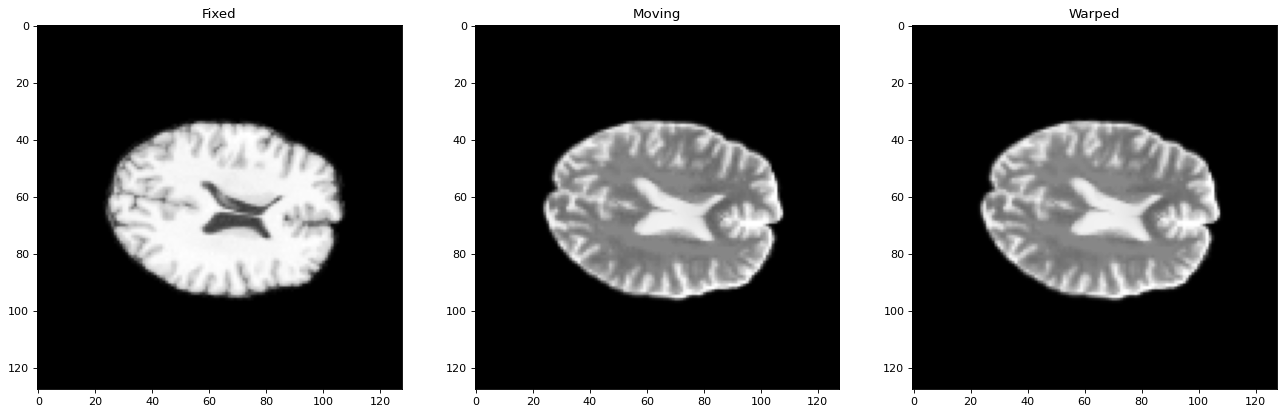

In [ ]:
fig = plt.figure(figsize=(20, 15), dpi=80)

#plt.subplot(1, 10, 1)
ax1 = fig.add_subplot(131)
ax1.title.set_text('Fixed')
plt.imshow(fixed_image_np[0, 0, :, 51, :], cmap='Greys_r')

#plt.subplot(1, 10, 2)

ax2 = fig.add_subplot(132)
ax2.title.set_text('Moving')
plt.imshow(moving_image_np[0, 0, :, 51, :], cmap='Greys_r')


ax3 = fig.add_subplot(133)
ax3.title.set_text('Warped')
#plt.subplot(1, 10, 3)
plt.imshow(warped_image_np[0, 0, :, 51, :], cmap='Greys_r')

plt.show()

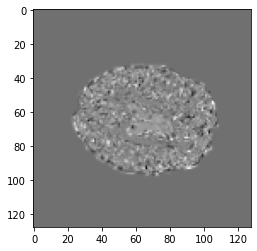

In [ ]:
plt.imshow( warped_image_np[0, 0, :, 51, :]-moving_image_np[0, 0, :, 51, :] , cmap='Greys_r')

In [ ]:
warped_image_tnsr = spatial_transformer_deformable(deformable_moving_img_tnsr, deformable_tnsr)
warped_image_np = warped_image_tnsr.detach().to("cpu").numpy()
plt.imshow(warped_image_np[0, 0, :, 75, :])